## 1. Data Preparation

In [61]:
# Import dependencies
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pathlib as Path
from scipy import stats

In [62]:
# List of file paths
file_paths = [
    "resources/StreamingHistory_music_0.json",
    "resources/StreamingHistory_music_1.json",
    "resources/StreamingHistory_music_2.json",
    "resources/StreamingHistory_podcast_0.json"
]

# Dictionary to store loaded JSON data
data = {}

# Load JSON files
for file_path in file_paths:
    with open(file_path) as json_file:
        data[file_path] = json.load(json_file)

# Access the loaded data
str0 = data["resources/StreamingHistory_music_0.json"]
str1 = data["resources/StreamingHistory_music_1.json"]
str2 = data["resources/StreamingHistory_music_2.json"]
str_p = data["resources/StreamingHistory_podcast_0.json"]

In [63]:
# Convert json dicts to dfs
df0 = pd.DataFrame(str0)
df1 = pd.DataFrame(str1)
df2 = pd.DataFrame(str2)
df_p = pd.DataFrame(str_p)

In [64]:
# Concatenate all streaming data dfs into one
merged_df = pd.concat([df0, df1, df2], ignore_index=True)

In [65]:
# View df
merged_df.head()

,endTime,artistName,trackName,msPlayed
0,2023-03-07 23:05,Young the Giant,Amerika,188690
1,2023-03-08 00:08,Young the Giant,Amerika,51449
2,2023-03-08 00:11,Enjoy,Small Car With Big Wheels,168028
3,2023-03-08 00:14,Machine Girl,Cloud99 (As Above Mix),200280
4,2023-03-08 00:18,Lianne La Havas,Forget,231520


In [66]:
# Check data types for df variables
merged_df.dtypes

endTime       object
artistName    object
trackName     object
msPlayed       int64
dtype: object

In [67]:
# Convert milliseconds played to minutes
merged_df['minPlayed'] = merged_df['msPlayed'] / 60000
merged_df.drop(columns='msPlayed', inplace=True)
merged_df.head()

,endTime,artistName,trackName,minPlayed
0,2023-03-07 23:05,Young the Giant,Amerika,3.144833
1,2023-03-08 00:08,Young the Giant,Amerika,0.857483
2,2023-03-08 00:11,Enjoy,Small Car With Big Wheels,2.800467
3,2023-03-08 00:14,Machine Girl,Cloud99 (As Above Mix),3.338000
4,2023-03-08 00:18,Lianne La Havas,Forget,3.858667


In [68]:
# Convert date to date time and make new variable for month and year
merged_df['endTime'] = pd.to_datetime(merged_df['endTime'])
merged_df['month_year'] = merged_df['endTime'].dt.to_period('M')
merged_df.head()

,endTime,artistName,trackName,minPlayed,month_year
0,2023-03-07 23:05:00,Young the Giant,Amerika,3.144833,2023-03
1,2023-03-08 00:08:00,Young the Giant,Amerika,0.857483,2023-03
2,2023-03-08 00:11:00,Enjoy,Small Car With Big Wheels,2.800467,2023-03
3,2023-03-08 00:14:00,Machine Girl,Cloud99 (As Above Mix),3.338000,2023-03
4,2023-03-08 00:18:00,Lianne La Havas,Forget,3.858667,2023-03


## 2. EDA

In [69]:
# Determine summary statistics table of int + date variables
summary_stats = merged_df.describe()
summary_stats

,endTime,minPlayed
count,21666,21666.000000
mean,2023-09-17 10:40:17.391304448,2.075392
min,2023-03-07 23:05:00,0.000000
25%,2023-06-08 13:07:00,0.149342
50%,2023-09-22 00:16:00,2.228000
75%,2023-12-27 19:48:00,3.494667
max,2024-03-08 23:58:00,27.024000
std,NaN,1.778507


In [70]:
# Determine top 10 artists by track playcount
top_artists_by_count = merged_df['artistName'].value_counts()
top_artists_by_count.head(10)

artistName
Taylor Swift         1868
Mac Miller            478
Olivia Rodrigo        406
The Front Bottoms     397
Glee Cast             373
One Direction         350
Nicki Minaj           316
Hiatus Kaiyote        279
Young the Giant       257
Machine Girl          228
Name: count, dtype: int64

In [71]:
# Determine top 10 artists by minutes listened
top_artists_by_minutes = merged_df.groupby('artistName')['minPlayed'].sum().sort_values(ascending=False)
top_artists_by_minutes.head(10)

artistName
Taylor Swift         4485.912450
Mac Miller           1322.707867
The Front Bottoms    1191.228133
Olivia Rodrigo       1078.369667
Glee Cast             841.244283
Young the Giant       774.547933
Nicki Minaj           745.452250
One Direction         693.491050
Hiatus Kaiyote        671.193233
Radiohead             534.915317
Name: minPlayed, dtype: float64

In [72]:
# Determine top 3 songs for each month by times played
top_songs_per_month = merged_df.groupby(['month_year', 'trackName']).size().reset_index(name='count')
top_songs_per_month = top_songs_per_month.sort_values(['month_year', 'count'], ascending=[True, False]).\
                                         groupby('month_year').head(3)
for month_year, group in top_songs_per_month.groupby('month_year'):
    print(f"\nTop 3 Songs for {month_year}:")
    print(group[['trackName', 'count']])


Top 3 Songs for 2023-03:
                           trackName  count
38                         Anti-Hero      7
245  Hot Girl (Bodies Bodies Bodies)      7
320                           Linger      7

Top 3 Songs for 2023-04:
                              trackName  count
719   All Of The Girls You Loved Before     16
1206                        Not Allowed     15
739                           Anti-Hero     14

Top 3 Songs for 2023-05:
          trackName  count
2383         Laputa     21
2565  New Romantics     17
2135       Gorgeous     14

Top 3 Songs for 2023-06:
             trackName  count
3589  Ex's House Party     26
4212     The Walk Home     16
3553      Dollar $tore     13

Top 3 Songs for 2023-07:
              trackName  count
5501            vampire     28
5054  Not Strong Enough     12
5375     Vampire Empire     10

Top 3 Songs for 2023-08:
             trackName  count
5832        HOT TO GO!     14
6053       Not Allowed     14
6077  Out Of The Woods     14

Top 3 S

In [73]:
# Group by month and year, and find the most frequently streamed song per month
top_song_per_month = merged_df.groupby(['month_year', 'trackName']).size().reset_index(name='count')
top_song_per_month = top_song_per_month.loc[top_song_per_month.groupby('month_year')['count'].idxmax()]

# Display the top song per month with song title and count in a table
print("Top Song per Month:")
print(top_song_per_month)

Top Song per Month:
      month_year                          trackName  count
38       2023-03                          Anti-Hero      7
719      2023-04  All Of The Girls You Loved Before     16
2383     2023-05                             Laputa     21
3589     2023-06                   Ex's House Party     26
5501     2023-07                            vampire     28
5832     2023-08                         HOT TO GO!     14
6713     2023-09                           Epiphany     29
8113     2023-10       Join Hands / With The Angels     12
9898     2023-11                              alone     13
10733    2023-12           Murder On The Dancefloor     27
12466    2024-01       Where You Are (feat. WILLOW)     21
12685    2024-02                   Archie, Marry Me     14
14715    2024-03                   Scroll of Sorrow      4


In [74]:
# Determine top 10 songs by count in the dataset
top_songs = merged_df.groupby('trackName').size().reset_index(name='count')
top_songs = top_songs.sort_values(by='count', ascending=False)
top_10_songs = top_songs.head(10)

In [75]:
# Determine top 10 Taylor Swift songs by times played

# Localize only the Taylor swift rows, group based on track name and minutes played
ts_only = merged_df.loc[merged_df['artistName'] == 'Taylor Swift']
songs_per_ts = ts_only.groupby('trackName')['minPlayed'].count().sort_values(ascending=False)

## 3. Hypothesis Testing and Correlation Coefficient Testing

In [76]:
# Determine if there is a significant difference between tracks played on weekdays vs weekends

# Calculate the number of streams per day
merged_df['date'] = merged_df['endTime'].dt.date
streams_per_day = merged_df.groupby('date').size()

# Convert index to datetime
streams_per_day.index = pd.to_datetime(streams_per_day.index)

# Grouping into weekdays and weekends
weekday_streams = streams_per_day[streams_per_day.index.dayofweek < 5]
weekend_streams = streams_per_day[streams_per_day.index.dayofweek >= 5]

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(weekday_streams, weekend_streams)

# Print the results
print("Results of the Hypothesis Test:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the average number of streams per day between weekdays and weekends.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the average number of streams per day between weekdays and weekends.")

Results of the Hypothesis Test:
T-statistic: -3.701780031533522
P-value: 0.0002475082260951417
Reject the null hypothesis: There is a significant difference in the average number of streams per day between weekdays and weekends.


In [77]:
# Determine correlation between number of streams and total minutes played per day

# Calculate the number of streams per day
merged_df['date'] = merged_df['endTime'].dt.date
streams_per_day = merged_df.groupby('date').size()

# Calculate the total minutes played per day
total_minutes_per_day = merged_df.groupby('date')['minPlayed'].sum()  # Convert milliseconds to minutes

# Calculate the correlation coefficient between 'streams_per_day' and 'total_minutes_per_day'
correlation_coefficient = streams_per_day.corr(total_minutes_per_day)

# Print the correlation coefficient
print("Correlation Coefficient between Streams per Day and Total Minutes Played per Day:", correlation_coefficient)

Correlation Coefficient between Streams per Day and Total Minutes Played per Day: 0.719679076235068


In [78]:
# Determine if there is a significant difference between top artists by count and top artists by minutes listened

# Perform two-sample t-test
t_statistic, p_value = stats.ttest_ind(top_artists_by_count, top_artists_by_minutes)

# Print the results
print("Results of the Hypothesis Test:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in top artists by tracks played vs minutes listened.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in in top artists by tracks played vs minutes listened.")

Results of the Hypothesis Test:
T-statistic: -3.9241362802932476
P-value: 8.823064986765359e-05
Reject the null hypothesis: There is a significant difference in top artists by tracks played vs minutes listened.


#### I am choosing to base top 10 artists on play count as count is more reflective of intentional listening than minutes since song lengths are variable.

## 4. Interpretation and Reporting

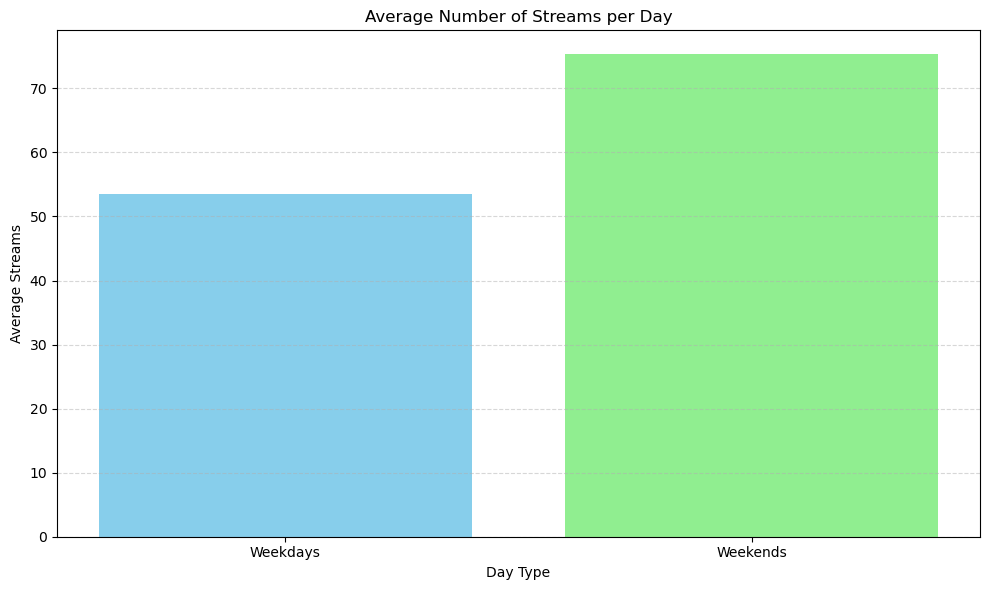

In [39]:
# Chart statistical difference between tracks played on weekdays vs weekends

# Plot
plt.figure(figsize=(10, 6))
plt.bar(['Weekdays', 'Weekends'], [weekday_streams.mean(), weekend_streams.mean()], color=['skyblue', 'lightgreen'])
plt.title('Average Number of Streams per Day')
plt.xlabel('Day Type')
plt.ylabel('Average Streams')
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add horizontal grid lines
plt.tight_layout()
plt.show()

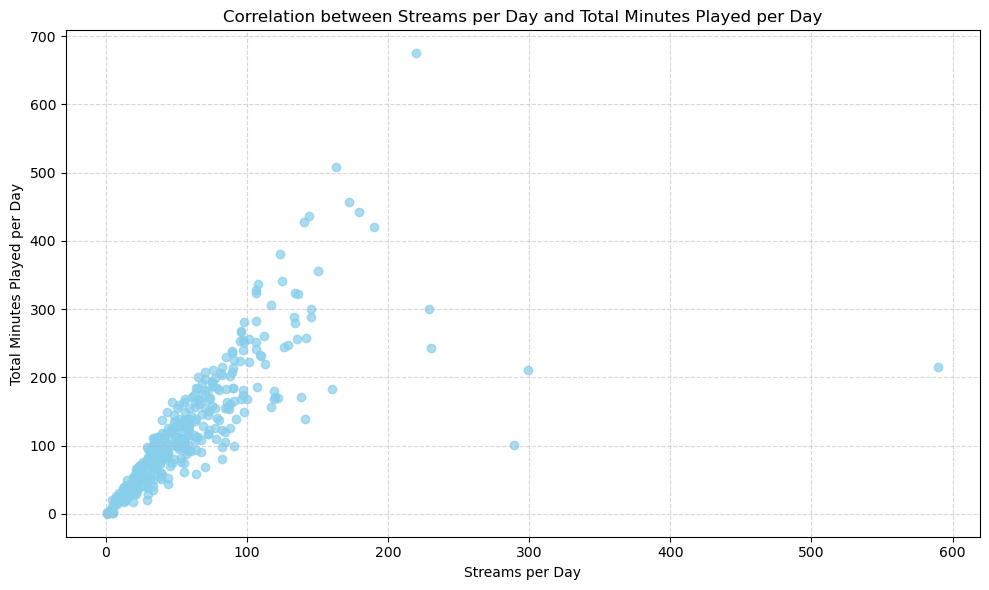

In [40]:
# Plot correlation between times played and minutes streamed
plt.figure(figsize=(10, 6))
plt.scatter(streams_per_day, total_minutes_per_day, color='skyblue', alpha=0.7)
plt.title('Correlation between Streams per Day and Total Minutes Played per Day')
plt.xlabel('Streams per Day')
plt.ylabel('Total Minutes Played per Day')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

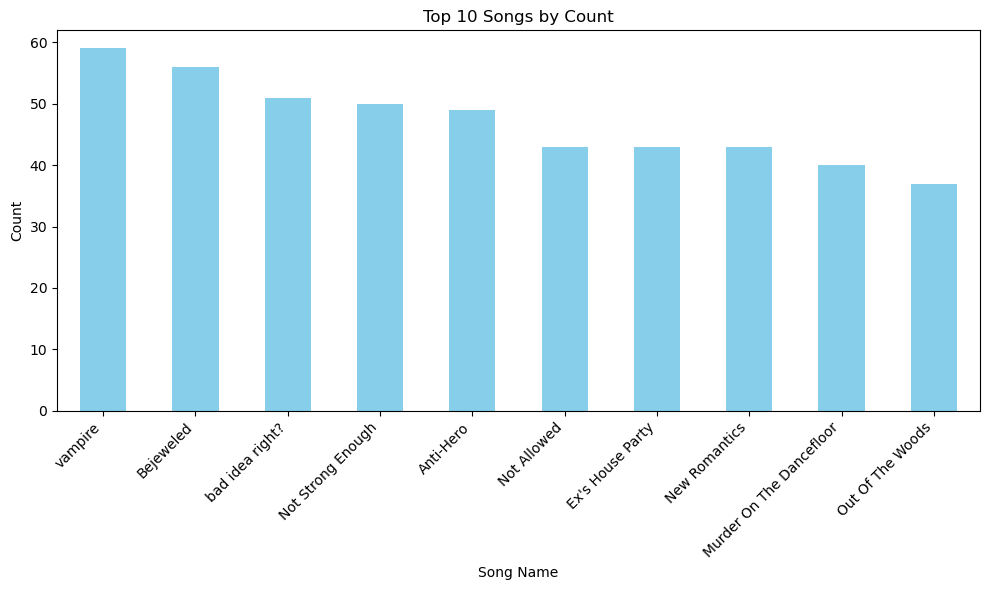

In [41]:
# Plot the top 10 songs in dataset by count
plt.figure(figsize=(10, 6))
top_10_songs.set_index('trackName')['count'].plot(kind='bar', color='skyblue')
plt.title('Top 10 Songs by Count')
plt.xlabel('Song Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

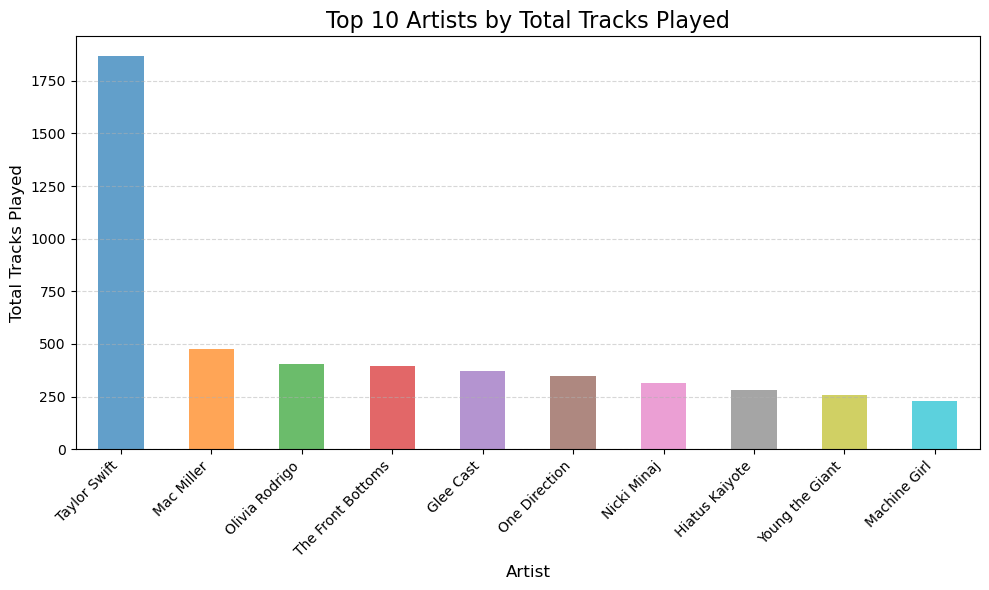

In [42]:
# Set a custom color palette
colors = plt.cm.tab10.colors

# Plot top 10 artists by minutes played
plt.figure(figsize=(10, 6))
top_artists_by_count.head(10).plot(kind='bar', color=colors, alpha=0.7)
plt.title('Top 10 Artists by Total Tracks Played', fontsize=16)
plt.xlabel('Artist', fontsize=12)
plt.ylabel('Total Tracks Played', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

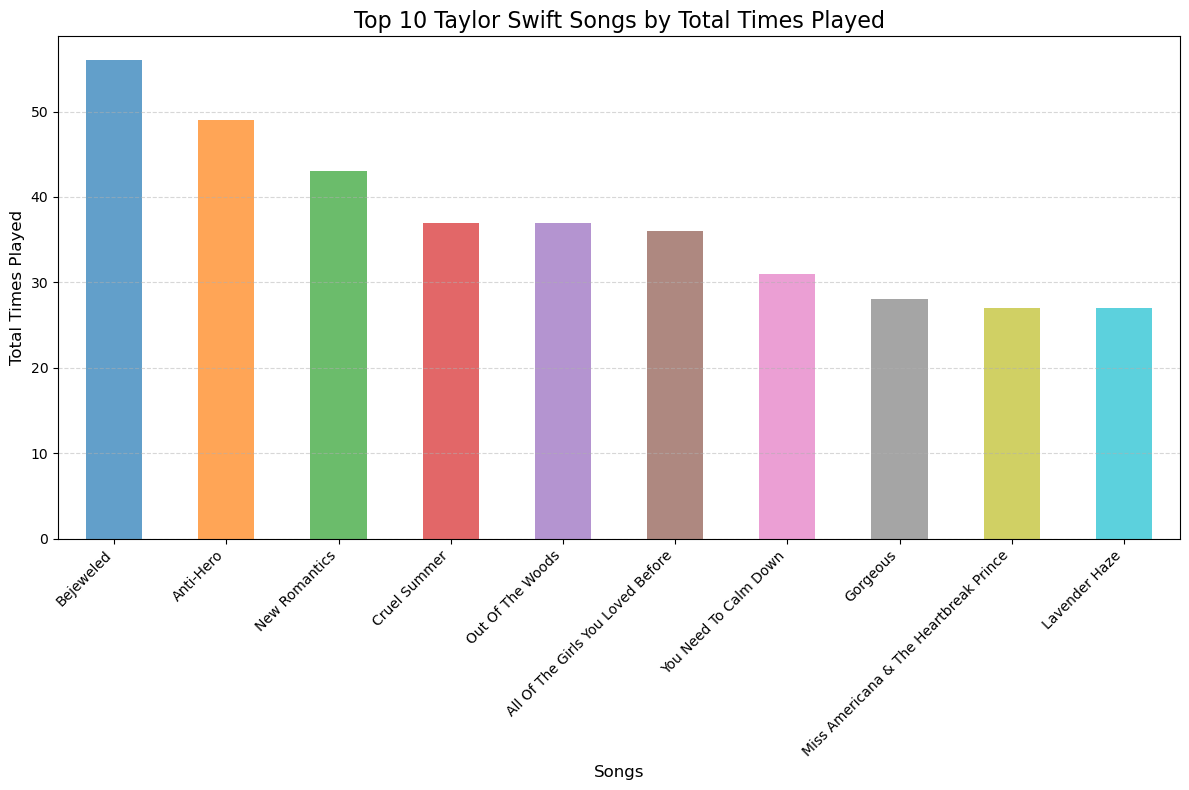

In [29]:
# Plot top 10 Taylor Swift songs by times played
colors = plt.cm.tab10.colors

plt.figure(figsize=(12, 8)) 
songs_per_ts.head(10).plot(kind='bar', color=colors, alpha=0.7) 
plt.title('Top 10 Taylor Swift Songs by Total Times Played', fontsize=16)
plt.xlabel('Songs', fontsize=12) 
plt.ylabel('Total Times Played', fontsize=12) 
plt.xticks(rotation=45, ha='right') 
plt.grid(axis='y', linestyle='--', alpha=0.5) 
plt.tight_layout()
plt.show()